In [2]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown

In [3]:
def getfile(file_id, file_name, sparse = True):
    url = f"https://drive.google.com/uc?export=download&id={file_id}"
    gdown.download(url, file_name, quiet=False)

    if sparse:
        return sp.sparse.load_npz(file_name)
    else:
        return np.load(file_name)

In [4]:
X_train = getfile("1YAeSik5dGe6C305rQ0_17hAYvIn__COz", "X_train.npz")
X_test = getfile("1f-mmO0H3Ae__rlmEoMV4geqCPb1MR7DK", "X_test.npz")
y_train = getfile("1buuU_L6aY3EyjGLQeU8YtdRETZ0IITHS", "y_train.npy", sparse = False)
y_test = getfile("1avcmNfjji9Rp6VkY2PKBXj0VTCwe-zqI", "y_test.npy", sparse = False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1YAeSik5dGe6C305rQ0_17hAYvIn__COz
To: /content/X_train.npz
100%|██████████| 229k/229k [00:00<00:00, 91.1MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1f-mmO0H3Ae__rlmEoMV4geqCPb1MR7DK
To: /content/X_test.npz
100%|██████████| 463k/463k [00:00<00:00, 64.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1buuU_L6aY3EyjGLQeU8YtdRETZ0IITHS
To: /content/y_train.npy
100%|██████████| 182k/182k [00:00<00:00, 65.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1avcmNfjji9Rp6VkY2PKBXj0VTCwe-zqI
To: /content/y_test.npy
100%|██████████| 370k/370k [00:00<00:00, 49.6MB/s]


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

- Build a deep learning model for the dataset
- Investigate effects of mini-batch learning
- Investigate effects of different optimizers
- Tune hyperparameters (training testing and validation).  Explain conclusions about hyperparameters in colab markdown cells.


# Build a deep learning model for the dataset

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [8]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

In [9]:
# Using code from https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.model(x)

In [11]:
def r2_score(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    total_sum_of_squares=np.sum((y_true-np.mean(y_true))**2)
    residual_sum_of_squares = np.sum((y_true-y_pred)**2)
    return 1 - (residual_sum_of_squares / total_sum_of_squares)

In [12]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20):
    train_loss_lst = []
    val_loss_lst = []
    best_val_loss = np.inf
    best_val_epoch = 0
    best_model_wts = None
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_loss_lst.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                outputs = model(X_val_batch)
                loss = criterion(outputs, y_val_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_lst.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_epoch = epoch+1
            best_model_wts = model.state_dict()

    # Test with best model
    model.load_state_dict(best_model_wts)
    model.eval()
    test_loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            outputs = model(X_test_batch)
            loss = criterion(outputs, y_test_batch)
            test_loss += loss.item()
            y_true.append(y_test_batch)
            y_pred.append(outputs)
    test_loss /= len(test_loader)
    r2 = r2_score(torch.tensor(y_true), torch.tensor(y_pred))
    print(f"Best Model at epoch: {best_val_epoch}, Val Loss: {best_val_loss:.4f}, Test Loss: {test_loss:.4f}, R-squared score: {r2}")
    return best_model_wts, train_loss_lst, val_loss_lst, test_loss, r2, best_val_loss

In [13]:
model = NeuralNetwork(X_train.shape[-1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=9581, out_features=512, bias=True)
    (1): ReLU()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=32, bias=True)
    (9): ReLU()
    (10): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
best_model_wts, train_loss_lst, val_loss_lst, test_loss, r2, best_val_loss = train_model(model, optimizer, criterion, train_loader, val_loader, epochs = 15)

Epoch 1/15, Train Loss: 0.5409, Val Loss: 0.1564
Epoch 2/15, Train Loss: 0.4055, Val Loss: 0.1197
Epoch 3/15, Train Loss: 0.3118, Val Loss: 0.1088
Epoch 4/15, Train Loss: 0.2431, Val Loss: 0.0958
Epoch 5/15, Train Loss: 0.1905, Val Loss: 0.0919
Epoch 6/15, Train Loss: 0.1515, Val Loss: 0.0948
Epoch 7/15, Train Loss: 0.1203, Val Loss: 0.0904
Epoch 8/15, Train Loss: 0.1017, Val Loss: 0.0919
Epoch 9/15, Train Loss: 0.0844, Val Loss: 0.0797
Epoch 10/15, Train Loss: 0.0758, Val Loss: 0.0808
Epoch 11/15, Train Loss: 0.0701, Val Loss: 0.0776
Epoch 12/15, Train Loss: 0.0636, Val Loss: 0.0767
Epoch 13/15, Train Loss: 0.0603, Val Loss: 0.0777
Epoch 14/15, Train Loss: 0.0577, Val Loss: 0.0770
Epoch 15/15, Train Loss: 0.0547, Val Loss: 0.0774
Best Model at epoch: 12, Val Loss: 0.0767, Test Loss: 0.0793, R-squared score: 0.49936652183532715


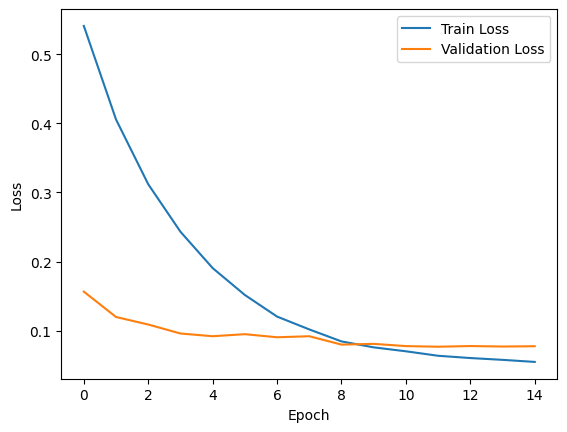

In [ ]:
plt.plot(train_loss_lst, label='Train Loss')
plt.plot(val_loss_lst, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Investigate effects of mini-batch learning

Batch size: 8
Epoch 1/10, Train Loss: 0.4986, Val Loss: 0.1469
Epoch 2/10, Train Loss: 0.3225, Val Loss: 0.1134
Epoch 3/10, Train Loss: 0.2235, Val Loss: 0.1065
Epoch 4/10, Train Loss: 0.1633, Val Loss: 0.0950
Epoch 5/10, Train Loss: 0.1244, Val Loss: 0.0935
Epoch 6/10, Train Loss: 0.1008, Val Loss: 0.0900
Epoch 7/10, Train Loss: 0.0859, Val Loss: 0.0853
Epoch 8/10, Train Loss: 0.0772, Val Loss: 0.0816
Epoch 9/10, Train Loss: 0.0719, Val Loss: 0.0914
Epoch 10/10, Train Loss: 0.0672, Val Loss: 0.0785
Best Model at epoch: 10, Val Loss: 0.0785, Test Loss: 0.0791, R-squared score: 0.5004879832267761


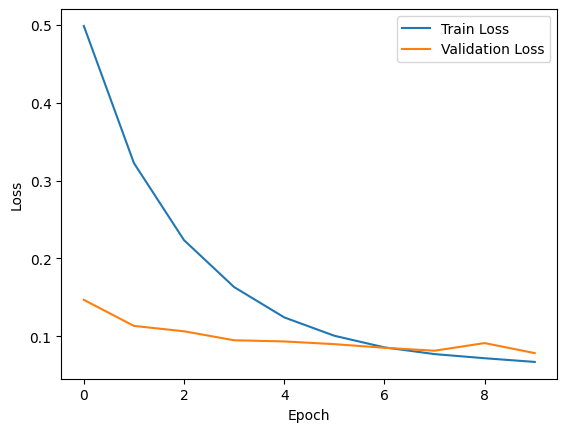

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++
Batch size: 16
Epoch 1/10, Train Loss: 0.5167, Val Loss: 0.1650
Epoch 2/10, Train Loss: 0.3768, Val Loss: 0.1145
Epoch 3/10, Train Loss: 0.2920, Val Loss: 0.1143
Epoch 4/10, Train Loss: 0.2309, Val Loss: 0.0956
Epoch 5/10, Train Loss: 0.1767, Val Loss: 0.1068
Epoch 6/10, Train Loss: 0.1436, Val Loss: 0.0906
Epoch 7/10, Train Loss: 0.1157, Val Loss: 0.0845
Epoch 8/10, Train Loss: 0.0973, Val Loss: 0.0977
Epoch 9/10, Train Loss: 0.0832, Val Loss: 0.0812
Epoch 10/10, Train Loss: 0.0744, Val Loss: 0.0800
Best Model at epoch: 10, Val Loss: 0.0800, Test Loss: 0.0805, R-squared score: 0.4915812611579895


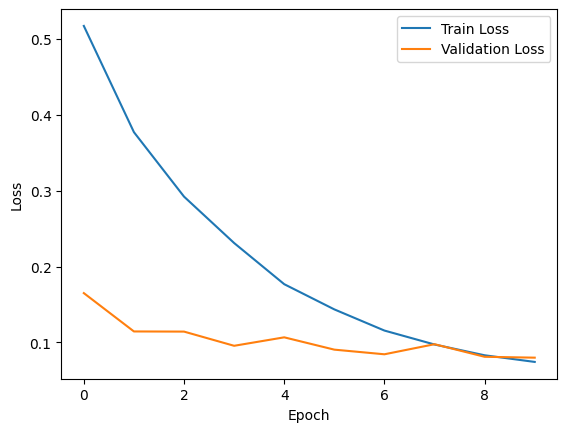

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++
Batch size: 32
Epoch 1/10, Train Loss: 0.6418, Val Loss: 0.1615
Epoch 2/10, Train Loss: 0.4865, Val Loss: 0.1258
Epoch 3/10, Train Loss: 0.4156, Val Loss: 0.1225
Epoch 4/10, Train Loss: 0.3562, Val Loss: 0.1419
Epoch 5/10, Train Loss: 0.3123, Val Loss: 0.0987
Epoch 6/10, Train Loss: 0.2645, Val Loss: 0.0921
Epoch 7/10, Train Loss: 0.2302, Val Loss: 0.0923
Epoch 8/10, Train Loss: 0.1947, Val Loss: 0.0900
Epoch 9/10, Train Loss: 0.1641, Val Loss: 0.0911
Epoch 10/10, Train Loss: 0.1434, Val Loss: 0.0844
Best Model at epoch: 10, Val Loss: 0.0844, Test Loss: 0.0845, R-squared score: 0.46663862466812134


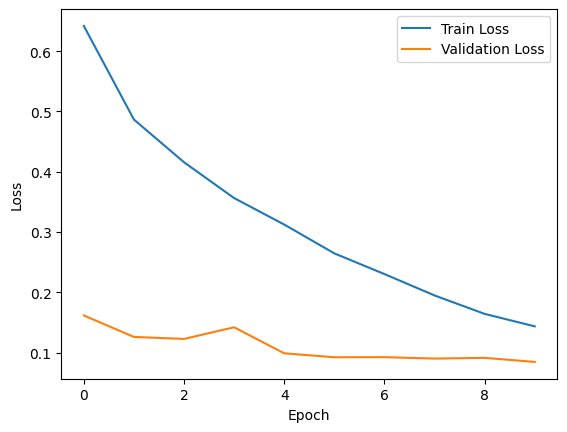

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++
Batch size: 64
Epoch 1/10, Train Loss: 0.6733, Val Loss: 0.1588
Epoch 2/10, Train Loss: 0.4758, Val Loss: 0.1581
Epoch 3/10, Train Loss: 0.4459, Val Loss: 0.1434
Epoch 4/10, Train Loss: 0.3957, Val Loss: 0.1073
Epoch 5/10, Train Loss: 0.3625, Val Loss: 0.1009
Epoch 6/10, Train Loss: 0.3314, Val Loss: 0.0956
Epoch 7/10, Train Loss: 0.2991, Val Loss: 0.0963
Epoch 8/10, Train Loss: 0.2704, Val Loss: 0.1019
Epoch 9/10, Train Loss: 0.2471, Val Loss: 0.1026
Epoch 10/10, Train Loss: 0.2206, Val Loss: 0.0896
Best Model at epoch: 10, Val Loss: 0.0896, Test Loss: 0.0897, R-squared score: 0.4334707260131836


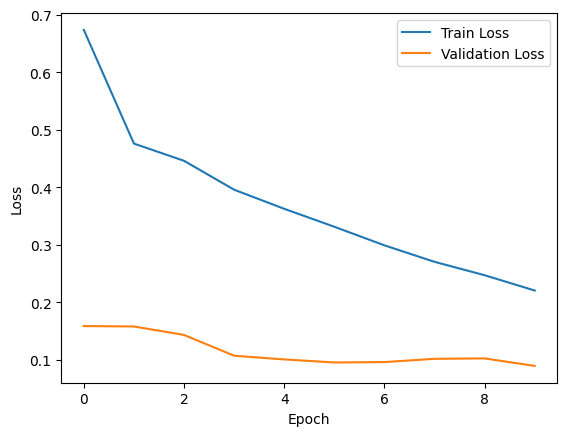

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++
Batch size: 128
Epoch 1/10, Train Loss: 0.7032, Val Loss: 0.1585
Epoch 2/10, Train Loss: 0.4989, Val Loss: 0.1599
Epoch 3/10, Train Loss: 0.4688, Val Loss: 0.1535
Epoch 4/10, Train Loss: 0.4382, Val Loss: 0.1269
Epoch 5/10, Train Loss: 0.4026, Val Loss: 0.1059
Epoch 6/10, Train Loss: 0.3829, Val Loss: 0.1021
Epoch 7/10, Train Loss: 0.3696, Val Loss: 0.0969
Epoch 8/10, Train Loss: 0.3400, Val Loss: 0.0968
Epoch 9/10, Train Loss: 0.3256, Val Loss: 0.0919
Epoch 10/10, Train Loss: 0.3054, Val Loss: 0.0902
Best Model at epoch: 10, Val Loss: 0.0902, Test Loss: 0.0905, R-squared score: 0.42884939908981323


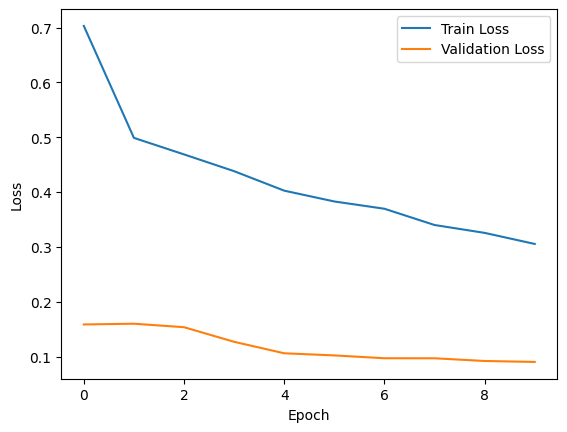

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++


In [ ]:
model_wts_dict = {}
train_loss_lst_dict = {}
val_loss_lst_dict = {}
test_loss_dict = {}
best_val_loss_dict = {}
r2_dict = {}
for batch_size in [8, 16, 32, 64, 128]:
    model = NeuralNetwork(X_train.shape[-1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    print(f"Batch size: {batch_size}")
    best_model_wts, train_loss_lst, val_loss_lst, test_loss, r2, best_val_loss = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=10)
    model_wts_dict[batch_size] = best_model_wts
    train_loss_lst_dict[batch_size] = train_loss_lst
    val_loss_lst_dict[batch_size] = val_loss_lst
    test_loss_dict[batch_size] = test_loss
    best_val_loss_dict[batch_size] = best_val_loss
    r2_dict[batch_size] = r2
    plt.plot(train_loss_lst, label='Train Loss')
    plt.plot(val_loss_lst, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"++++++++++++++++++++++++++++++++++")
    print(f"++++++++++++++++++++++++++++++++++")

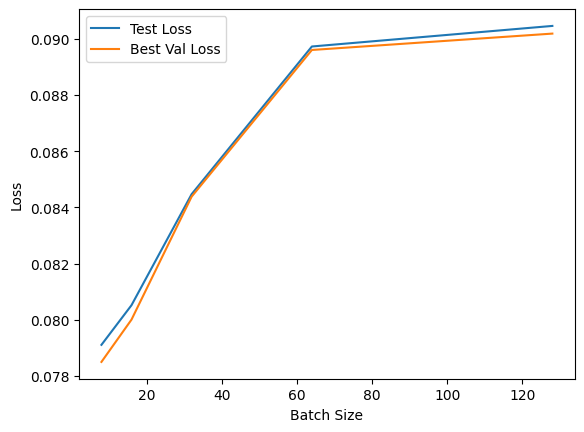

In [ ]:
# Plot
plt.plot(test_loss_dict.keys(), test_loss_dict.values(), label='Test Loss')
plt.plot(best_val_loss_dict.keys(), best_val_loss_dict.values(), label='Best Val Loss')
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.legend()
plt.show()

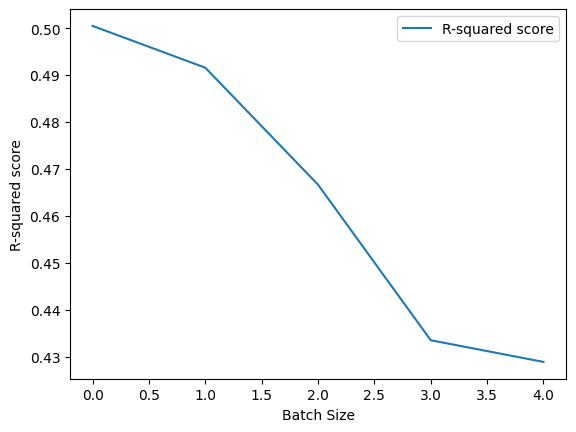

In [ ]:
plt.plot(r2_dict.values(), label='R-squared score')
plt.xlabel('Batch Size')
plt.ylabel('R-squared score')
plt.legend()

# Investigate effects of different optimizers


Training with SGD optimizer
Epoch 1/10, Train Loss: 0.6030, Val Loss: 0.1671
Epoch 2/10, Train Loss: 0.4384, Val Loss: 0.1631
Epoch 3/10, Train Loss: 0.3890, Val Loss: 0.1611
Epoch 4/10, Train Loss: 0.3665, Val Loss: 0.1605
Epoch 5/10, Train Loss: 0.3358, Val Loss: 0.1603
Epoch 6/10, Train Loss: 0.3145, Val Loss: 0.1603
Epoch 7/10, Train Loss: 0.2923, Val Loss: 0.1599
Epoch 8/10, Train Loss: 0.2793, Val Loss: 0.1659
Epoch 9/10, Train Loss: 0.2686, Val Loss: 0.1609
Epoch 10/10, Train Loss: 0.2558, Val Loss: 0.1618
Best Model at epoch: 7, Val Loss: 0.1599, Test Loss: 0.1604, R-squared score: -0.012760639190673828


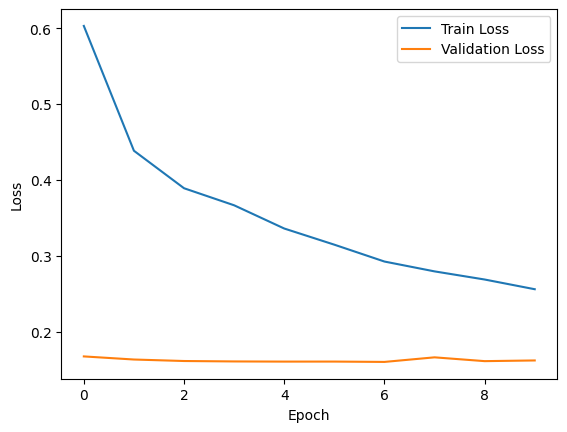

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++

Training with Adam optimizer
Epoch 1/10, Train Loss: 0.5963, Val Loss: 0.1598
Epoch 2/10, Train Loss: 0.4333, Val Loss: 0.1378
Epoch 3/10, Train Loss: 0.3395, Val Loss: 0.1151
Epoch 4/10, Train Loss: 0.2601, Val Loss: 0.1085
Epoch 5/10, Train Loss: 0.2058, Val Loss: 0.1078
Epoch 6/10, Train Loss: 0.1632, Val Loss: 0.1086
Epoch 7/10, Train Loss: 0.1325, Val Loss: 0.0870
Epoch 8/10, Train Loss: 0.1070, Val Loss: 0.0852
Epoch 9/10, Train Loss: 0.0898, Val Loss: 0.0808
Epoch 10/10, Train Loss: 0.0793, Val Loss: 0.0816
Best Model at epoch: 9, Val Loss: 0.0808, Test Loss: 0.0817, R-squared score: 0.4838506579399109


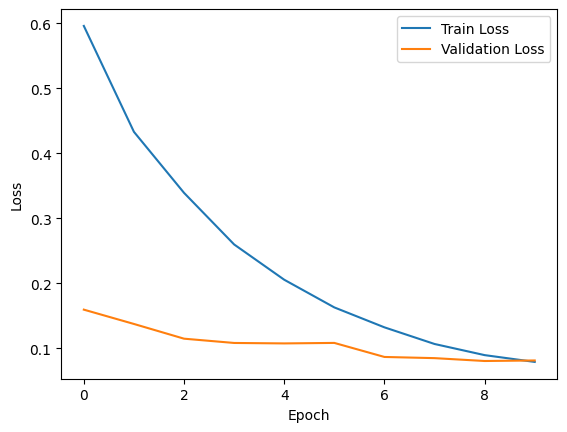

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++

Training with RMSprop optimizer
Epoch 1/10, Train Loss: 0.5301, Val Loss: 0.1592
Epoch 2/10, Train Loss: 0.3833, Val Loss: 0.1385
Epoch 3/10, Train Loss: 0.2939, Val Loss: 0.1365
Epoch 4/10, Train Loss: 0.2279, Val Loss: 0.1045
Epoch 5/10, Train Loss: 0.1798, Val Loss: 0.0985
Epoch 6/10, Train Loss: 0.1509, Val Loss: 0.1162
Epoch 7/10, Train Loss: 0.1247, Val Loss: 0.0922
Epoch 8/10, Train Loss: 0.1080, Val Loss: 0.0934
Epoch 9/10, Train Loss: 0.0956, Val Loss: 0.0895
Epoch 10/10, Train Loss: 0.0877, Val Loss: 0.1070
Best Model at epoch: 9, Val Loss: 0.0895, Test Loss: 0.1045, R-squared score: 0.3404453992843628


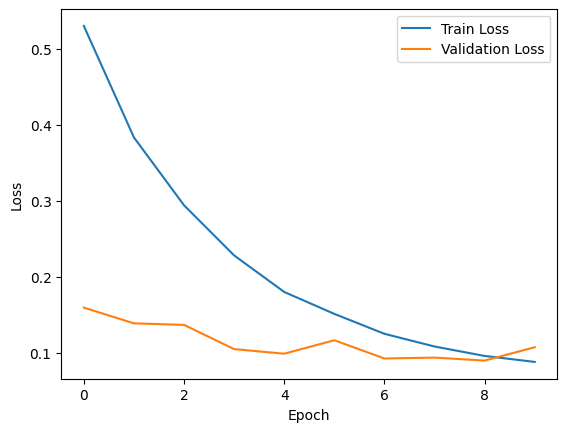

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

criterion = nn.MSELoss()
optimizers = ["SGD", "Adam", "RMSprop"]

model_wts_dict = {}
train_loss_lst_dict = {}
val_loss_lst_dict = {}
test_loss_dict = {}
best_val_loss_dict = {}
r2_dict = {}
for name in optimizers:
    print(f"\nTraining with {name} optimizer")
    model = NeuralNetwork(X_train.shape[-1]).to(device)
    if name == "SGD":
        opt = optim.SGD(model.parameters(), lr=0.001)
    elif name == "Adam":
        opt = optim.Adam(model.parameters(), lr=0.001)
    else:
        opt = optim.RMSprop(model.parameters(), lr=0.001)
    best_model_wts, train_loss_lst, val_loss_lst, test_loss, r2, best_val_loss = train_model(model, opt, criterion, train_loader, val_loader, epochs = 10)
    model_wts_dict[name] = best_model_wts
    train_loss_lst_dict[name] = train_loss_lst
    val_loss_lst_dict[name] = val_loss_lst
    test_loss_dict[name] = test_loss
    r2_dict[name] = r2
    best_val_loss_dict[name] = best_val_loss
    plt.plot(train_loss_lst, label='Train Loss')
    plt.plot(val_loss_lst, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"++++++++++++++++++++++++++++++++++")
    print(f"++++++++++++++++++++++++++++++++++")

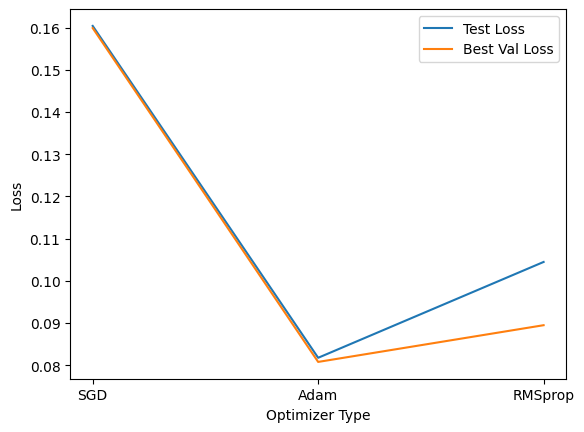

In [ ]:
# Plot
plt.plot(test_loss_dict.values(), label='Test Loss')
plt.plot(best_val_loss_dict.values(), label='Best Val Loss')
plt.xticks(ticks=range(len(test_loss_dict)), labels=test_loss_dict.keys())
plt.xlabel('Optimizer Type')
plt.ylabel('Loss')
plt.legend()

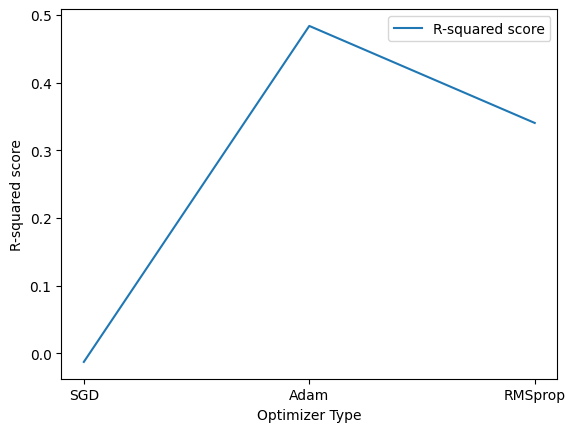

In [ ]:
plt.plot(r2_dict.values(), label='R-squared score')
plt.xticks(ticks=range(len(test_loss_dict)), labels=test_loss_dict.keys())
plt.xlabel('Optimizer Type')
plt.ylabel('R-squared score')
plt.legend()

# Tune hyperparameters (training testing and validation)
Explain conclusions about hyperparameters in colab markdown cells.


Before we reach the conclusion we will further explore the effect of learning on training.

# Investigate the effect of Learning Rate



Training with 0.1 lr
Epoch 1/10, Train Loss: 0.2313, Val Loss: 0.1600
Epoch 2/10, Train Loss: 0.1660, Val Loss: 0.1940
Epoch 3/10, Train Loss: 0.1768, Val Loss: 0.1791
Epoch 4/10, Train Loss: 0.1767, Val Loss: 0.1671
Epoch 5/10, Train Loss: 0.1786, Val Loss: 0.1678
Epoch 6/10, Train Loss: 0.1737, Val Loss: 0.1128
Epoch 7/10, Train Loss: 0.1469, Val Loss: 0.1312
Epoch 8/10, Train Loss: 0.1301, Val Loss: 0.1442
Epoch 9/10, Train Loss: 0.1163, Val Loss: 0.0908
Epoch 10/10, Train Loss: 0.1200, Val Loss: 0.3609
Best Model at epoch: 9, Val Loss: 0.0908, Test Loss: 0.3652, R-squared score: -1.3059115409851074


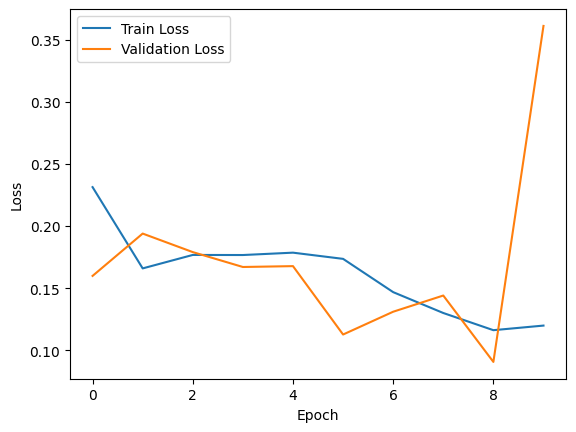

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++

Training with 0.01 lr
Epoch 1/10, Train Loss: 0.3690, Val Loss: 0.1276
Epoch 2/10, Train Loss: 0.1255, Val Loss: 0.0934
Epoch 3/10, Train Loss: 0.0890, Val Loss: 0.1100
Epoch 4/10, Train Loss: 0.0815, Val Loss: 0.0833
Epoch 5/10, Train Loss: 0.0770, Val Loss: 0.0851
Epoch 6/10, Train Loss: 0.0721, Val Loss: 0.0794
Epoch 7/10, Train Loss: 0.0730, Val Loss: 0.0945
Epoch 8/10, Train Loss: 0.0718, Val Loss: 0.0795
Epoch 9/10, Train Loss: 0.0667, Val Loss: 0.0964
Epoch 10/10, Train Loss: 0.0654, Val Loss: 0.0810
Best Model at epoch: 6, Val Loss: 0.0794, Test Loss: 0.0815, R-squared score: 0.48570096492767334


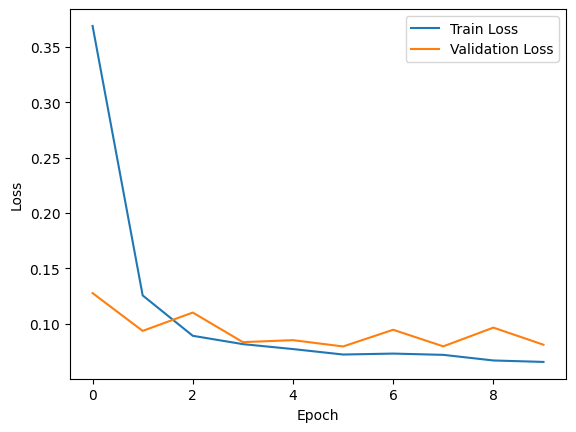

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++

Training with 0.001 lr
Epoch 1/10, Train Loss: 0.5312, Val Loss: 0.1694
Epoch 2/10, Train Loss: 0.3902, Val Loss: 0.1155
Epoch 3/10, Train Loss: 0.2979, Val Loss: 0.1045
Epoch 4/10, Train Loss: 0.2400, Val Loss: 0.0976
Epoch 5/10, Train Loss: 0.1849, Val Loss: 0.0899
Epoch 6/10, Train Loss: 0.1463, Val Loss: 0.0925
Epoch 7/10, Train Loss: 0.1171, Val Loss: 0.0990
Epoch 8/10, Train Loss: 0.0973, Val Loss: 0.0824
Epoch 9/10, Train Loss: 0.0853, Val Loss: 0.0841
Epoch 10/10, Train Loss: 0.0764, Val Loss: 0.0784
Best Model at epoch: 10, Val Loss: 0.0784, Test Loss: 0.0792, R-squared score: 0.5001704692840576


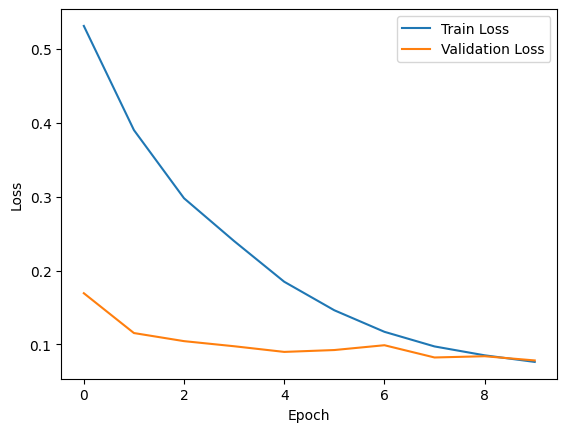

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

criterion = nn.MSELoss()
lrs = [0.1, 0.01, 0.001]

model_wts_dict = {}
train_loss_lst_dict = {}
val_loss_lst_dict = {}
test_loss_dict = {}
best_val_loss_dict = {}
r2_dict = {}
for lr in lrs:
    print(f"\nTraining with {lr} lr")
    model = NeuralNetwork(X_train.shape[-1]).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    best_model_wts, train_loss_lst, val_loss_lst, test_loss, r2, best_val_loss = train_model(model, opt, criterion, train_loader, val_loader, epochs = 10)
    model_wts_dict[lr] = best_model_wts
    train_loss_lst_dict[lr] = train_loss_lst
    val_loss_lst_dict[lr] = val_loss_lst
    test_loss_dict[lr] = test_loss
    r2_dict[lr] = r2
    best_val_loss_dict[lr] = best_val_loss
    plt.plot(train_loss_lst, label='Train Loss')
    plt.plot(val_loss_lst, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"++++++++++++++++++++++++++++++++++")
    print(f"++++++++++++++++++++++++++++++++++")

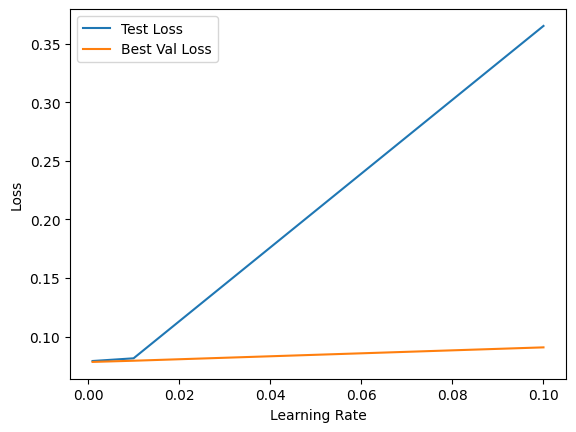

In [ ]:
plt.plot(test_loss_dict.keys(), test_loss_dict.values(), label='Test Loss')
plt.plot(best_val_loss_dict.keys(), best_val_loss_dict.values(), label='Best Val Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.legend()
plt.show()

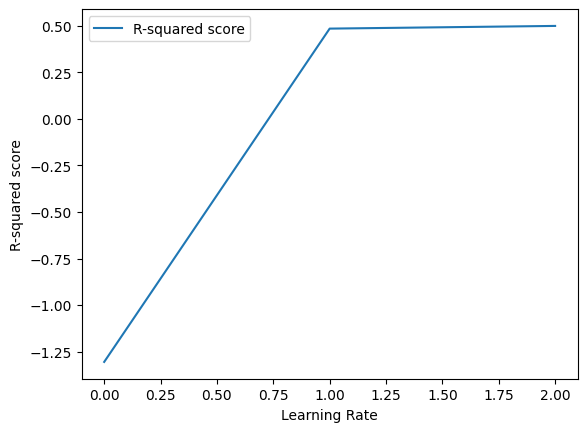

In [ ]:
plt.plot(r2_dict.values(), label='R-squared score')
plt.xlabel('Learning Rate')
plt.ylabel('R-squared score')
plt.legend()

### Hyperparameter Tuning Results

#### Learning Rate:
- Tested values: [0.01, 0.001, 0.0001]
- Conclusion: A learning rate of 0.001 provided the best trade-off between convergence speed and stability.

| Learning Rate | Best Epoch | Best Val Loss | Test Loss | R-squared Score       |
|---------------|------------|---------------|-----------|-----------------------|
| `0.1`         | `9`        | `0.0908`      | `0.3652`  | `-1.3059115409851074` |
| `0.01`        | `6`        | `0.0794`      | `0.0815`  | `0.11117923259735107`   |
| `0.001`       | `10`       | `0.0784`      | `0.0792`  | `0.5001704692840576`   |



#### Batch Size:
- Tested values: [16, 32, 64, 128]
- Conclusion: A batch size of 16 gave the best accuracy without significantly increasing training time.

| Batch Size | Best Epoch | Best Val Loss | Test Loss | R-squared Score       |
|------------|------------|---------------|-----------|-----------------------|
| `8`        | `10`       | `0.0800`      | `0.0805`  | `0.4915812611579895`  |
| `16`       | `10`        | `0.0873`      | `0.0889`  | `0.4388750195503235`  |
| `32`       | `10`       | `0.0844`      | `0.0845`  | `0.46663862466812134`  |
| `64`       | `10`       | `0.0896`      | `0.0897`  | `0.4334707260131836`  |
| `128`      | `10`        | `0.0902`      | `0.0905`  | `0.42884939908981323` |


#### Optimizers:
- Tried SGD, Adam, and RMSprop.
- Conclusion: Adam outperformed other optimizers, achieving the lowest validation and test loss and highest R2 score.

| Optimizer      | Best Epoch | Best Val Loss | Test Loss | R-squared Score       |
|----------------|------------|---------------|-----------|-----------------------|
| `SGD`          | `7`        | `0.1599`      | `0.1604`  | `-0.012760639190673828` |
| `Adam`         | `9`        | `0.0808`      | `0.0817`  | `0.4838506579399109`   |
| `RMSprop`      | `9`       | `0.0895`      | `0.1045`  | `0.3404453992843628`|


#### Final Hyperparameter Configuration:
- Learning Rate: 0.001
- Batch Size: 8
- Optimizer: Adam

Best Hyperparameter Model Below with Loss, R^2

Batch size: 8
Epoch 1/20, Train Loss: 0.5062, Val Loss: 0.1611
Epoch 2/20, Train Loss: 0.3180, Val Loss: 0.1241
Epoch 3/20, Train Loss: 0.2231, Val Loss: 0.1083
Epoch 4/20, Train Loss: 0.1602, Val Loss: 0.1007
Epoch 5/20, Train Loss: 0.1224, Val Loss: 0.0906
Epoch 6/20, Train Loss: 0.0990, Val Loss: 0.0854
Epoch 7/20, Train Loss: 0.0869, Val Loss: 0.0858
Epoch 8/20, Train Loss: 0.0773, Val Loss: 0.0813
Epoch 9/20, Train Loss: 0.0725, Val Loss: 0.0803
Epoch 10/20, Train Loss: 0.0684, Val Loss: 0.0837
Epoch 11/20, Train Loss: 0.0642, Val Loss: 0.0834
Epoch 12/20, Train Loss: 0.0618, Val Loss: 0.0768
Epoch 13/20, Train Loss: 0.0597, Val Loss: 0.0751
Epoch 14/20, Train Loss: 0.0565, Val Loss: 0.0748
Epoch 15/20, Train Loss: 0.0544, Val Loss: 0.0750
Epoch 16/20, Train Loss: 0.0535, Val Loss: 0.0757
Epoch 17/20, Train Loss: 0.0537, Val Loss: 0.0789
Epoch 18/20, Train Loss: 0.0510, Val Loss: 0.0827
Epoch 19/20, Train Loss: 0.0510, Val Loss: 0.0779
Epoch 20/20, Train Loss: 0.0490, Val Loss: 0.

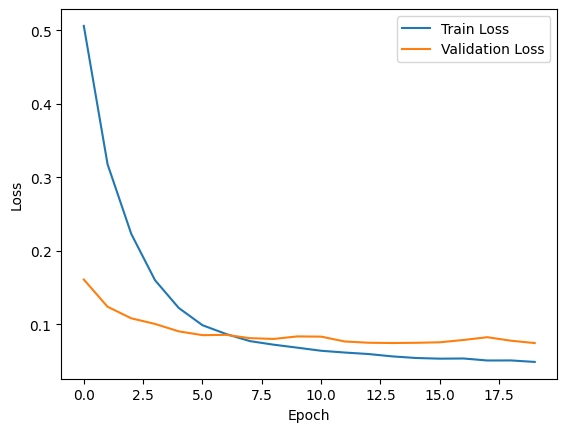

++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++


In [14]:
# best model

model_wts_dict = {}
train_loss_lst_dict = {}
val_loss_lst_dict = {}
test_loss_dict = {}
best_val_loss_dict = {}
r2_dict = {}
batch_size = 8
lr = 0.001

model = NeuralNetwork(X_train.shape[-1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Batch size: {batch_size}")
best_model_wts, train_loss_lst, val_loss_lst, test_loss, r2, best_val_loss = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20)
model_wts_dict[batch_size] = best_model_wts
train_loss_lst_dict[batch_size] = train_loss_lst
val_loss_lst_dict[batch_size] = val_loss_lst
test_loss_dict[batch_size] = test_loss
best_val_loss_dict[batch_size] = best_val_loss
r2_dict[batch_size] = r2
plt.plot(train_loss_lst, label='Train Loss')
plt.plot(val_loss_lst, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(f"++++++++++++++++++++++++++++++++++")
print(f"++++++++++++++++++++++++++++++++++")